# DeepLoc learning notebook
To use this notebook you don't need to interact with any code, just run cells in order and a graphical user interface will pop-up showcasing the parameters for each step.

In [1]:
import sys
sys.path.append('../../')
import ipywidgets as widgets
from IPython.display import display
import stackview
import datetime

import ailoc.deeploc
import ailoc.common
ailoc.common.setup_seed(42)

%matplotlib inline

## 1. Set the necessary parameters to train the network, mainly about the training data simulation

In [2]:
deeploc_learn_param_widget = ailoc.common.DeepLocSetLearnParamWidget()
deeploc_learn_param_widget.display_notebook_gui()

SelectFilesButton(description='Select the calibration file', icon='square-o', layout=Layout(height='80px', wid…

DeepLocSetPSFParamWidget(children=(Button(description='Load from calib', layout=Layout(grid_area='widget001'),…

GridspecLayout(children=(Label(value='Camera parameters', layout=Layout(grid_area='widget001')), Dropdown(desc…

DeepLocSetSamplerParamWidget(children=(Label(value='Sampler parameters', layout=Layout(grid_area='widget001'))…

Button(description='OK', style=ButtonStyle())

Output()

## 2. Initialize the DeepLoc model

In [4]:
deeploc_model = ailoc.deeploc.DeepLoc(deeploc_learn_param_widget.deeploc_params_dict['psf_params_dict'],
                                      deeploc_learn_param_widget.deeploc_params_dict['camera_params_dict'],
                                      deeploc_learn_param_widget.deeploc_params_dict['sampler_params_dict'])

## 3. Check the PSF model used for training data simulation 

checking PSF...


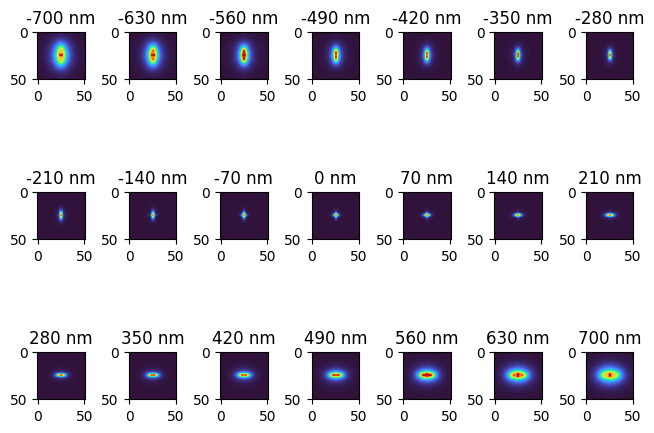

checking training data...


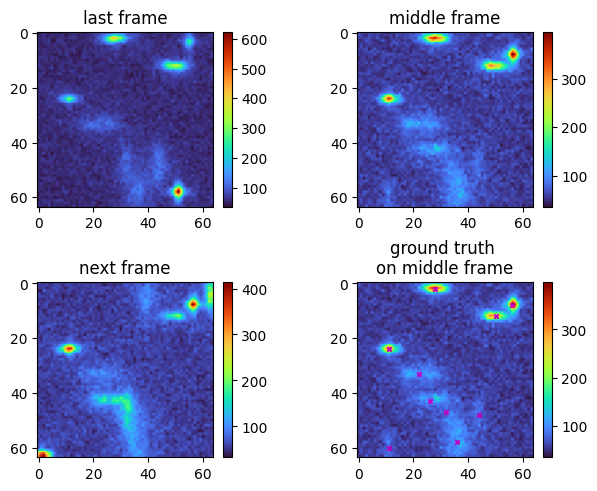

In [5]:
deeploc_model.check_training_psf()
deeploc_model.check_training_data()

## 4. Simulate a validation dataset to track the network performance

In [6]:
deeploc_model.build_evaluation_dataset(napari_plot=False)
display(stackview.slice(deeploc_model.evaluation_dataset['data'][:,0], colormap='turbo', continuous_update=True))

building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([1000, 3, 64, 64]) building done! contain 5034 target molecules, time cost: 7.28s


## 5. Your are ready to go training the network!

In [7]:
file_name = '../../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'DeepLoc'
deeploc_model.online_train(batch_size=10, max_iterations=30000, eval_freq=500, file_name=file_name)

Start training...
training from checkpoint, the recent performance is:
No recent performance record found
----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 6400.0, 0, 6400.0), border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 3729, predictions: 3336, please waiting...
evaluating done! time cost: 2.79s
Iterations: 1004 || Loss: 25.65 || IterTime: 291.51 ms || ETA: 2.35 h || SumProb: 5.20 || Eff_3D: 45.49 || Jaccard: 0.80 || Recall: 0.84 || Precision: 0.94 || RMSE_lat: 42.10 || RMSE_ax: 117.79
DeepLoc instance saved to ../../results/2023-08-31-14DeepLoc.pt
----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 6400.0, 0, 6400.0), border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 3729, predictions: 3419, please waiting...
evaluating done! time cost: 2.73s
Iterations: 

KeyboardInterrupt: 